# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from tqdm.auto import tqdm

import numpy as np
import h5py

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import MultiStepLR, StepLR

In [3]:
!pip install einops

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
os.chdir("/content/drive/MyDrive/MRViT")

In [6]:
from models.mrvit import MultiResViT
from dataset.dataset import get_datasets

In [7]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = "cuda:0"
    print('using device: cuda')
else:
    device = "cpu"
    print('using device: cpu')

using device: cuda


# Dataset

In [9]:
train_dataset, valid_dataset, test_dataset = get_datasets()

<KeysViewHDF5 ['label_test', 'label_train', 'test', 'test_small', 'train', 'train_small']>
torch.Size([624, 112, 112, 1]) torch.Size([624, 28, 28, 1]) torch.Size([624, 1])
4703 4708


In [10]:
BATCH_SIZE = 128
num_classes = 2

In [11]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset) // 4)

In [12]:
for batch_data in train_loader:
    print(batch_data[0].shape)
    print(batch_data[1].shape)
    print(batch_data[2].shape)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 1])


# Merged Model

In [13]:
mrv = MultiResViT(4)

img_s = torch.randn(2, 3, 224, 224)
img_b = torch.randn(2, 3, 224, 224)

pred = mrv(img_s, img_b)

print(pred)

tensor([[ 0.2585,  0.2348,  0.2527, -0.0271],
        [ 0.2589,  0.2354,  0.2527, -0.0259]], grad_fn=<AddmmBackward>)


# Training


In [14]:
weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_dataset.get_labels().numpy()),
                                                 train_dataset.get_labels().numpy())
weights = torch.FloatTensor(weights).to(device)

In [15]:
weights

tensor([2.0258, 0.6638], device='cuda:0')

In [16]:
epochs = 50
lr = 2.5e-4
decay = 0.1
gamma = 0.7

model = MultiResViT(nclasses = num_classes) #Put model to be trained and tested
model.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight = weights)
# optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=decay)
# scheduler
scheduler = MultiStepLR(optimizer, [20, 40])

In [17]:
keys = ['epochs', 'loss', 'acc', 'val_loss', 'val_acc']
history = {key: [] for key in keys}

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in tqdm(train_loader):
        images_s = batch_data[0].to(device)
        images_l = batch_data[1].to(device)
        label = batch_data[2].to(device)

        output = model(images_s, images_l)

        loss = criterion(output.float(), label.flatten())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        acc = accuracy_score(output.argmax(dim=1).detach().cpu().float(), label.detach().cpu().float())
        epoch_accuracy += acc 
        epoch_loss += loss 

    with torch.no_grad(): 
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for batch_data in tqdm(valid_loader):
            images_s = batch_data[0].to(device)
            images_l = batch_data[1].to(device)
            label = batch_data[2].to(device)

            val_output = model(images_s, images_l)
            val_loss = criterion(val_output.float(), label.flatten())

            acc = accuracy_score(val_output.argmax(dim=1).detach().cpu().float(), label.detach().cpu().float())
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss
    
    scheduler.step()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss/ len(train_loader):.4f} - acc: {epoch_accuracy/ len(train_loader):.4f} \
        - val_loss : {epoch_val_loss / len(valid_loader):.4f} - val_acc: {epoch_val_accuracy / len(valid_loader):.4f}\n"
    )
    history['epochs'].append(epoch+1)
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_accuracy)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_accuracy)


Epoch : 1 - loss : 0.5003 - acc: 0.6931         - val_loss : 0.9039 - val_acc: 0.5000




Epoch : 2 - loss : 0.3126 - acc: 0.8608         - val_loss : 1.0061 - val_acc: 0.5000




Epoch : 3 - loss : 0.2560 - acc: 0.8757         - val_loss : 0.9901 - val_acc: 0.5000




Epoch : 4 - loss : 0.2469 - acc: 0.8963         - val_loss : 1.1448 - val_acc: 0.5000




Epoch : 5 - loss : 0.2404 - acc: 0.8851         - val_loss : 0.9802 - val_acc: 0.5000




Epoch : 6 - loss : 0.2346 - acc: 0.8870         - val_loss : 0.7797 - val_acc: 0.5000




Epoch : 7 - loss : 0.2494 - acc: 0.8894         - val_loss : 0.8581 - val_acc: 0.7500




Epoch : 8 - loss : 0.2514 - acc: 0.8905         - val_loss : 1.2182 - val_acc: 0.5000




Epoch : 9 - loss : 0.2164 - acc: 0.9016         - val_loss : 1.1590 - val_acc: 0.7500




Epoch : 10 - loss : 0.2134 - acc: 0.9052         - val_loss : 0.9623 - val_acc: 0.5000




Epoch : 11 - loss : 0.2153 - acc: 0.9069         - val_loss : 1.6975 - val_acc: 0.5000




Epoch : 12 - loss : 0.2132 - acc: 0.9104         - val_loss : 1.4090 - val_acc: 0.5000




Epoch : 13 - loss : 0.2052 - acc: 0.9065         - val_loss : 0.9598 - val_acc: 0.5000




Epoch : 14 - loss : 0.1853 - acc: 0.9191         - val_loss : 1.0227 - val_acc: 0.5000




Epoch : 15 - loss : 0.1866 - acc: 0.9127         - val_loss : 1.0943 - val_acc: 0.5000




Epoch : 16 - loss : 0.1929 - acc: 0.9167         - val_loss : 1.0642 - val_acc: 0.5000




Epoch : 17 - loss : 0.1661 - acc: 0.9254         - val_loss : 1.1320 - val_acc: 0.5000




Epoch : 18 - loss : 0.1754 - acc: 0.9253         - val_loss : 1.4068 - val_acc: 0.5000




Epoch : 19 - loss : 0.1906 - acc: 0.9121         - val_loss : 1.2946 - val_acc: 0.5000




Epoch : 20 - loss : 0.1914 - acc: 0.9110         - val_loss : 0.9806 - val_acc: 0.5000




Epoch : 21 - loss : 0.1682 - acc: 0.9199         - val_loss : 1.0816 - val_acc: 0.7500




Epoch : 22 - loss : 0.1552 - acc: 0.9312         - val_loss : 1.1607 - val_acc: 0.7500




Epoch : 23 - loss : 0.1512 - acc: 0.9331         - val_loss : 1.1536 - val_acc: 0.7500




Epoch : 24 - loss : 0.1437 - acc: 0.9355         - val_loss : 1.2320 - val_acc: 0.5000




Epoch : 25 - loss : 0.1375 - acc: 0.9402         - val_loss : 1.2588 - val_acc: 0.5000




Epoch : 26 - loss : 0.1323 - acc: 0.9382         - val_loss : 1.1513 - val_acc: 0.5000




Epoch : 27 - loss : 0.1418 - acc: 0.9355         - val_loss : 1.1037 - val_acc: 0.7500




Epoch : 28 - loss : 0.1225 - acc: 0.9411         - val_loss : 1.2645 - val_acc: 0.5000




Epoch : 29 - loss : 0.1361 - acc: 0.9441         - val_loss : 1.2208 - val_acc: 0.5000




Epoch : 30 - loss : 0.1249 - acc: 0.9423         - val_loss : 1.2303 - val_acc: 0.5000




Epoch : 31 - loss : 0.1229 - acc: 0.9431         - val_loss : 1.2909 - val_acc: 0.5000




Epoch : 32 - loss : 0.1231 - acc: 0.9431         - val_loss : 1.3264 - val_acc: 0.5000




Epoch : 33 - loss : 0.1192 - acc: 0.9443         - val_loss : 1.2858 - val_acc: 0.5000




Epoch : 34 - loss : 0.1179 - acc: 0.9448         - val_loss : 1.2897 - val_acc: 0.5000




Epoch : 35 - loss : 0.1213 - acc: 0.9445         - val_loss : 1.2755 - val_acc: 0.5000




Epoch : 36 - loss : 0.1178 - acc: 0.9474         - val_loss : 1.3508 - val_acc: 0.5000




Epoch : 37 - loss : 0.1124 - acc: 0.9516         - val_loss : 1.4401 - val_acc: 0.5000




Epoch : 38 - loss : 0.1188 - acc: 0.9440         - val_loss : 1.2210 - val_acc: 0.5000




Epoch : 39 - loss : 0.1077 - acc: 0.9516         - val_loss : 1.3264 - val_acc: 0.5000




Epoch : 40 - loss : 0.1102 - acc: 0.9494         - val_loss : 1.4181 - val_acc: 0.5000




Epoch : 41 - loss : 0.1048 - acc: 0.9512         - val_loss : 1.4108 - val_acc: 0.5000




Epoch : 42 - loss : 0.1023 - acc: 0.9549         - val_loss : 1.4722 - val_acc: 0.5000




Epoch : 43 - loss : 0.0995 - acc: 0.9551         - val_loss : 1.3602 - val_acc: 0.7500




Epoch : 44 - loss : 0.1043 - acc: 0.9527         - val_loss : 1.4250 - val_acc: 0.5000




Epoch : 45 - loss : 0.1037 - acc: 0.9540         - val_loss : 1.4692 - val_acc: 0.5000




Epoch : 46 - loss : 0.1019 - acc: 0.9514         - val_loss : 1.2817 - val_acc: 0.5000




Epoch : 47 - loss : 0.0978 - acc: 0.9559         - val_loss : 1.3585 - val_acc: 0.7500




Epoch : 48 - loss : 0.0996 - acc: 0.9515         - val_loss : 1.4701 - val_acc: 0.7500




Epoch : 49 - loss : 0.0961 - acc: 0.9564         - val_loss : 1.4916 - val_acc: 0.5000




Epoch : 50 - loss : 0.1027 - acc: 0.9531         - val_loss : 1.3423 - val_acc: 0.7500



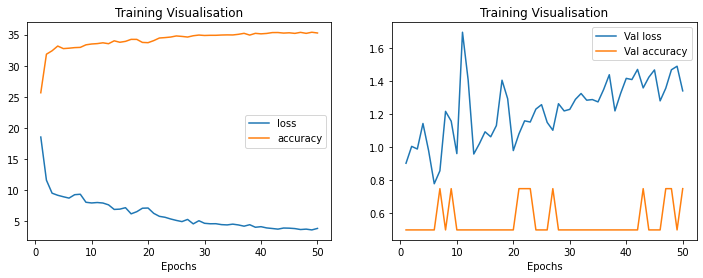

In [18]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['epochs'], history['loss'], label='loss') 
plt.plot(history['epochs'], history['acc'], label='accuracy')
plt.xlabel('Epochs')
plt.title("Training Visualisation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['epochs'], history['val_loss'], label='Val loss')
plt.plot(history['epochs'], history['val_acc'], label='Val accuracy')
plt.xlabel('Epochs')
plt.title("Training Visualisation")
plt.legend()

In [19]:
test_acc = 0
test_auc = 0
preds = []

with torch.no_grad():
    model.eval()
    for batch_data in tqdm(test_loader):
        images_s = batch_data[0].to(device)
        images_l = batch_data[1].to(device)
        label = batch_data[2].to(device)

        test_output = model(images_s, images_l)
        
        acc = accuracy_score(label.detach().cpu().float(), test_output.argmax(dim=1).detach().cpu().float()) 
        if num_classes == 2:
            auc = roc_auc_score(label.detach().cpu().float(), test_output.argmax(dim=1).detach().cpu().float(), average = "weighted")
        else:
            auc = roc_auc_score(F.one_hot(label, num_classes = num_classes)[:, 0, :].detach().cpu().float(), test_output.detach().cpu().float() / torch.sum(test_output).cpu(), average="weighted")
       
        preds.append(test_output.argmax(dim=1).detach().cpu().numpy())

        test_acc += acc
        test_auc += auc

preds = [a.squeeze().tolist() for a in preds]

In [20]:
print(f"ACC Model: {test_acc / len(test_loader)}, AUC Model: {test_auc / len(test_loader)}")

ACC Model: 0.875, AUC Model: 0.8514909853572182


In [21]:
preds = [item for sublist in preds for item in sublist]
preds = np.array([np.array(y) for y in preds], dtype=float)

In [22]:
print(classification_report(test_dataset.get_labels(), preds.flatten()))

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       234
         1.0       0.87      0.95      0.90       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624

